In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
import os
IMG_SHAPE = (512, 512)
N_CHANNELS = 1
INPUT_SHAPE = (256, 256, 1)
N_CLASSES = 1
BATCH_SIZE = 20
DATASET_PATH = f"{os.path.expanduser('~')}/Datasets/SEGTHOR_EXTRACTED"
from model import EfficientUnet

model = EfficientUnet(input_shape = INPUT_SHAPE)
model.load_weights(f"records/{model.name}/best/checkpoint/{model.name}")

import segmentation_models as sm
dice_score = sm.metrics.FScore(threshold=0.5)
precision_score = tf.keras.metrics.Precision(thresholds=0.5)
recall_score = tf.keras.metrics.Recall(thresholds=0.5)
iou_score = sm.metrics.IOUScore(threshold=0.5)

2023-10-24 17:07:19.856298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 17:07:19.946779: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 17:07:19.970223: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 17:07:20.400700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Segmentation Models: using `keras` framework.


2023-10-24 17:07:21.129661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 17:07:21.130196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 17:07:21.130640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 17:07:21.460678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 17:07:21.461156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# Get Training History

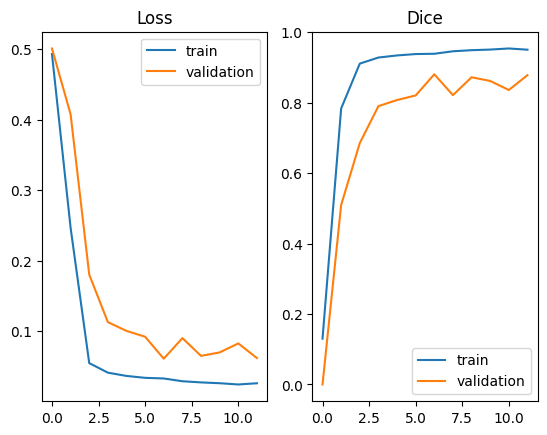

In [2]:
import pickle
import matplotlib.pyplot as plt

with open(f"records/{model.name}/best/history", "rb") as f:
    history = pickle.load(f)

train_loss = history["loss"]
val_loss = history["val_loss"]

train_f1 = history["f1-score"]
val_f1 = history["val_f1-score"]

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train", "validation"])

plt.subplot(1, 2, 2)
plt.title("Dice")
plt.plot(train_f1)
plt.plot(val_f1)
plt.legend(["train", "validation"])

# Metrics Without Post Processing

In [3]:
import numpy as np
from glob import glob
import tfpreprocessing as tfp
from segthor_generators import PatientSliceGenerator
import preprocessing as pre

preprocessing_pipeline = tfp.Pipeline([
    pre.resize((256, 256)),
    pre.windowing(-89, 66),
    pre.norm(),
    pre.expand_dims(),
])

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

patients_test = glob(DATASET_PATH + '/val/*')

for patient in patients_test:
    patient_dataset = tf.data.Dataset.from_generator(
        PatientSliceGenerator(patient, preprocessing_pipeline),
        output_signature=
        (
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32)
        )
    )

    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))
    volume_pred = model.predict(patient_dataset.batch(20), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)

    metrics["dice"].append(dice_score(volume_true, volume_pred))
    metrics["precision"].append(precision_score(volume_true, volume_pred))
    metrics["recall"].append(recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(iou_score(volume_true, volume_pred))
    
for k in metrics.keys():
    print(f"{k} : {np.mean(metrics[k])}")

2023-10-24 17:07:26.181673: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-24 17:07:26.639039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


dice : 0.6469449400901794
precision : 0.5383210182189941
recall : 0.9035781621932983
iou_score : 0.48952847719192505


# Metrics With Post Processing

In [4]:
import numpy as np
import tfpreprocessing as tfp
import postprocessing
from glob import glob
from segthor_generators import PatientSliceGenerator

preprocessing_pipeline = tfp.Pipeline([
    pre.resize((256, 256)),
    pre.windowing(-89, 66),
    pre.norm(),
    pre.expand_dims(),
])

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

patients_test = glob(DATASET_PATH + '/val/*')

for patient in patients_test:
    patient_dataset = tf.data.Dataset.from_generator(
        PatientSliceGenerator(patient, preprocessing_pipeline),
        output_signature=
        (
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32)
        )
    )

    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))
    volume_pred = model.predict(patient_dataset.batch(20), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)
    volume_pred = postprocessing.biggest_3D_object(volume_pred)

    metrics["dice"].append(dice_score(volume_true, volume_pred))
    metrics["precision"].append(precision_score(volume_true, volume_pred))
    metrics["recall"].append(recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(iou_score(volume_true, volume_pred))

for k in metrics.keys():
    print(f"{k} : {np.mean(metrics[k])}")

dice : 0.7346790432929993
precision : 0.5589405298233032
recall : 0.8978834748268127
iou_score : 0.5880833268165588
